In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import (Input, LSTM, Dense, Concatenate, AdditiveAttention)

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
df = pd.read_csv("Electric_Consumption.csv")
df.head()

C:\Users\selva\AppData\Local\Temp\ipykernel_29132\1493009690.py:1: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Electric_Consumption.csv")


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [3]:
df.shape

(2075259, 9)

In [4]:
df["Datetime"] = pd.to_datetime( df["Date"] + " " + df["Time"], format="%d/%m/%Y %H:%M:%S")

df.drop(columns=["Date", "Time"], inplace=True)
df.set_index("Datetime", inplace=True)

In [5]:
df.replace("?", np.nan, inplace=True)
df = df.astype(float)
df = df.resample("h").mean()
df = df.dropna()

In [6]:
df.shape

(34168, 7)

In [7]:
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [8]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df.values.astype(np.float32))

print("NaNs in scaled_data:", np.isnan(scaled_data).sum())

NaNs in scaled_data: 0


In [9]:
def create_sequences(data, input_len=24, output_len=1):
    X, y = [], []
    for i in range(len(data) - input_len - output_len):
        X.append(data[i:i+input_len])
        y.append(data[i+input_len:i+input_len+output_len, 0])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, input_len=24, output_len=1)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [10]:
baseline = tf.keras.Sequential([LSTM(64, input_shape=(X.shape[1], X.shape[2])), Dense(1)])

baseline.compile(optimizer=Adam(learning_rate=0.001), loss="mse")

baseline.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, verbose=1)

C:\Users\selva\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
769/769 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - loss: 0.0103 - val_loss: 0.0097
Epoch 2/10
769/769 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - loss: 0.0084 - val_loss: 0.0085
Epoch 3/10
769/769 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - loss: 0.0080 - val_loss: 0.0083
Epoch 4/10
769/769 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - loss: 0.0078 - val_loss: 0.0082
Epoch 5/10
769/769 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - loss: 0.0077 - val_loss: 0.0082
Epoch 6/10
769/769 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - loss: 0.0076 - val_loss: 0.0084
Epoch 7/10
769/769 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - loss: 0.0076 - val_loss: 0.0084
Epoch 8/10
769/769 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - loss: 0.0075 - val_loss: 0.0079
Epoch 9/10
769/769 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - loss: 0.0074 - val_loss: 0.0079
Epoch 10/10
769/769 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - loss: 0.0074 - val_loss: 0.0081


In [11]:
# Encoder
encoder_inputs = Input(shape=(X.shape[1], X.shape[2]))
encoder_outputs, state_h, state_c = LSTM(64, return_sequences=True, return_state=True)(encoder_inputs)

# Decoder
decoder_inputs = Input(shape=(1, X.shape[2]))
decoder_outputs = LSTM(64, return_sequences=True)(decoder_inputs, initial_state=[state_h, state_c])

# Additive Attention (STABLE)
attention = AdditiveAttention()
context = attention([decoder_outputs, encoder_outputs])

# Concatenate
decoder_concat = Concatenate(axis=-1)([decoder_outputs, context])

# Final output
output = Dense(1)(decoder_concat)

# Model
attention_model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=output)

attention_model.compile(optimizer=Adam(learning_rate=0.0003,clipnorm=1.0), loss="mse")

attention_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 24, 7)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_2 (InputLayer)    │ (None, 1, 7)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_1 (LSTM)                 │ [(None, 24, 64), (None,   │          18,432 │ input_layer_1[0][0]        │
│                               │ 64), (None, 64)]          │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_2 (LSTM)                 │ (None, 1, 64)             │          18,432 │ input_layer_2[0][0],       │
│                               │                           │                 │ lstm_1[0][1], lstm_1[0][2] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ additive_attention            │ (None, 1, 64)             │              64 │ lstm_2[0][0], lstm_1[0][0] │
│ (AdditiveAttention)           │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 1, 128)            │               0 │ lstm_2[0][0],              │
│                               │                           │                 │ additive_attention[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 1, 1)              │             129 │ concatenate[0][0]          │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 37,057 (144.75 KB)

 Trainable params: 37,057 (144.75 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
decoder_train_input = X_train[:, -1:, :]
decoder_test_input  = X_test[:, -1:, :]

attention_model.fit([X_train, decoder_train_input], y_train.reshape(-1, 1, 1), epochs=20, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/20
769/769 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - loss: 0.0116 - val_loss: 0.0098
Epoch 2/20
769/769 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - loss: 0.0088 - val_loss: 0.0094
Epoch 3/20
769/769 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - loss: 0.0085 - val_loss: 0.0088
Epoch 4/20
769/769 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - loss: 0.0083 - val_loss: 0.0088
Epoch 5/20
769/769 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - loss: 0.0082 - val_loss: 0.0089
Epoch 6/20
769/769 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - loss: 0.0081 - val_loss: 0.0086
Epoch 7/20
769/769 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - loss: 0.0080 - val_loss: 0.0089
Epoch 8/20
769/769 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - loss: 0.0079 - val_loss: 0.0085
Epoch 9/20
769/769 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - loss: 0.0078 - val_loss: 0.0084
Epoch 10/20
769/769 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - loss: 0.0077 - val_loss: 0.0084
Epoch 11/20
769/769 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - loss: 0.0077 - val_loss: 0.0083
Epoch 12/20
769/769 ━━━━━━━━━━

In [13]:
preds = attention_model.predict([X_test, decoder_test_input])

y_pred = preds.flatten()
y_true = y_test.flatten()

print("NaNs in y_true:", np.isnan(y_true).sum())
print("NaNs in y_pred:", np.isnan(y_pred).sum())

print("Attention MAE:", mean_absolute_error(y_true, y_pred))
print("Attention RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))

214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
NaNs in y_true: 0
NaNs in y_pred: 0
Attention MAE: 0.053937286138534546
Attention RMSE: 0.07805891818509984


In [14]:
baseline_preds = baseline.predict(X_test).flatten()

print("Baseline MAE:", mean_absolute_error(y_true, baseline_preds))
print("Baseline RMSE:", np.sqrt(mean_squared_error(y_true, baseline_preds)))

214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Baseline MAE: 0.05385494977235794
Baseline RMSE: 0.07681772112115068


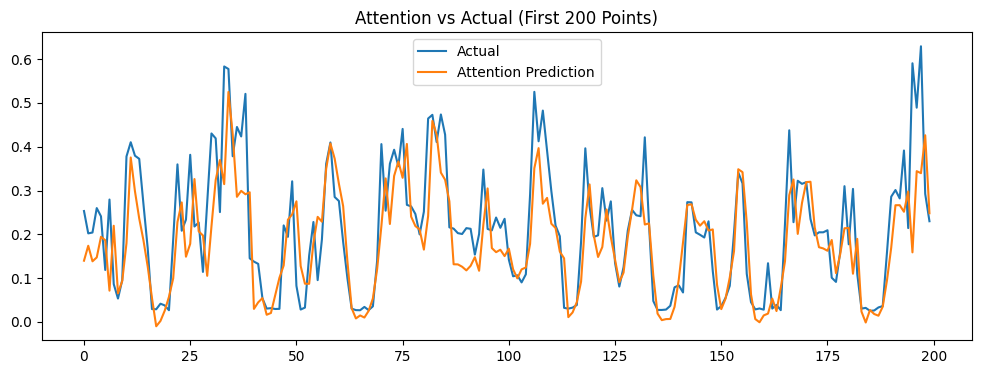

In [15]:
plt.figure(figsize=(12,4))
plt.plot(y_true[:200], label="Actual")
plt.plot(y_pred[:200], label="Attention Prediction")
plt.legend()
plt.title("Attention vs Actual (First 200 Points)")
plt.show()